# Overview of respiration data preprocessing and analysis
This tutorial covers a basic pipeline for preprocessing and analysis of respiration data collected during a experimental task. It introduces core `pyriodic` classes.


At first, we import the necessary Python modules:

In [70]:
import pickle

from pyriodic.preproc import RawSignal
from pyriodic.viz import plot_phase_diagnostics
from pyriodic.phase_events import create_phase_events


## Load in data and create `RawSignal` object

The first step is to load in the respiration time series data. Together with the sampling frequency, this is used to create a `RawSignal` object. This object holds many useful methods for preprocessing the raw data. 


In [71]:
# load data
with open("../../data/respiration/example.pkl", "rb") as file:
    data = pickle.load(file)

# extract respiration timeseries and sampling frequency
resp_ts = data["respiration_timeseries"].get_data().squeeze()
sfreq = data["respiration_timeseries"].info["sfreq"]


# initialise RawSignal object
raw = RawSignal(resp_ts, fs = sfreq)

The `RawSignal` object has a built-in plotting method that allows you to visualise the data. You can specify the start time and duration of the segment you want to plot. If no arguments are provided, it will plot the first 20 seconds of the signal. 

<Axes: xlabel='Time (s)', ylabel='Amplitude'>

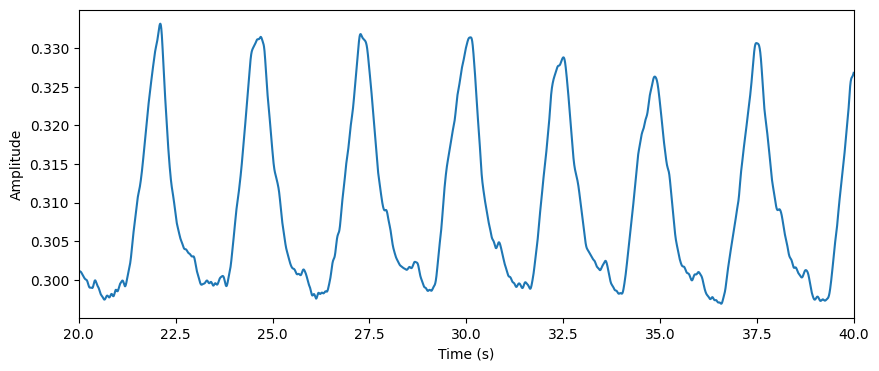

In [72]:
raw.plot(start = 20, duration = 20)

## Preprocessing


<Axes: xlabel='Time (s)', ylabel='Amplitude'>

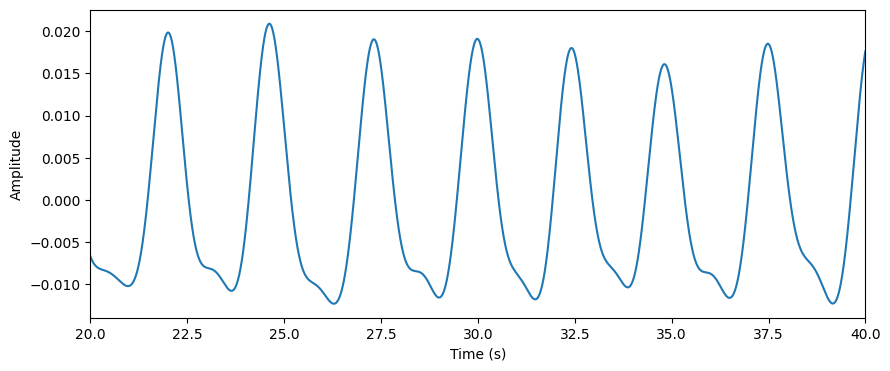

In [73]:
raw.filter_bandpass(low = 0.1, high = 1)
raw.plot(start = 20, duration = 20)

<Axes: xlabel='Time (s)', ylabel='Amplitude'>

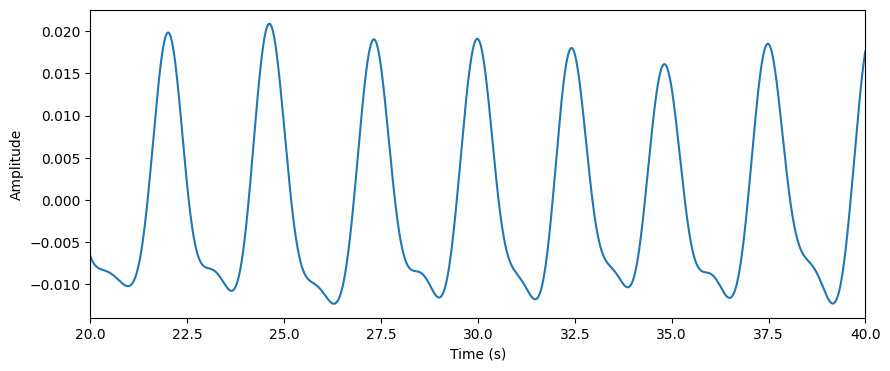

In [74]:
raw.smoothing(window_size=50)
raw.plot(start = 20, duration = 20)

<Axes: xlabel='Time (s)', ylabel='Amplitude'>

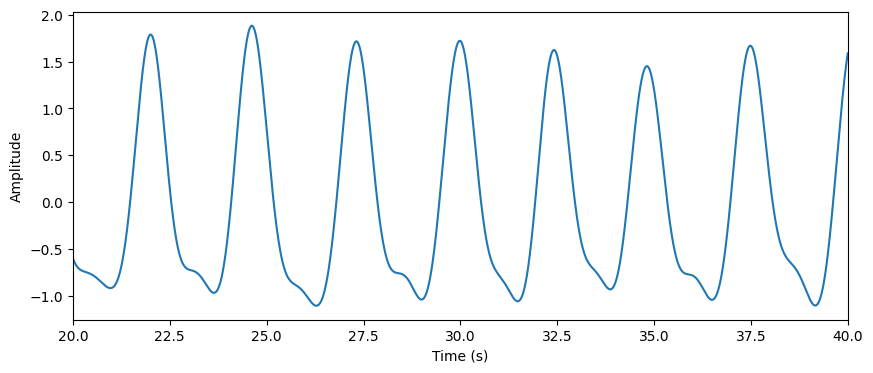

In [75]:
raw.zscore()
raw.plot(start = 20, duration = 20)

As the data is modified in-place, the original signal is lost. If you want to keep the original signal, make a copy before applying any modifications. To see which modifications have been applied to the signal, you can print the history:

In [76]:
raw.history

['bandpass(0.1 Hz - 1 Hz)',
 'Smoothing has been applied with a window size of 50',
 'zscore()']

### Extract phase angles

start_idx 1200000


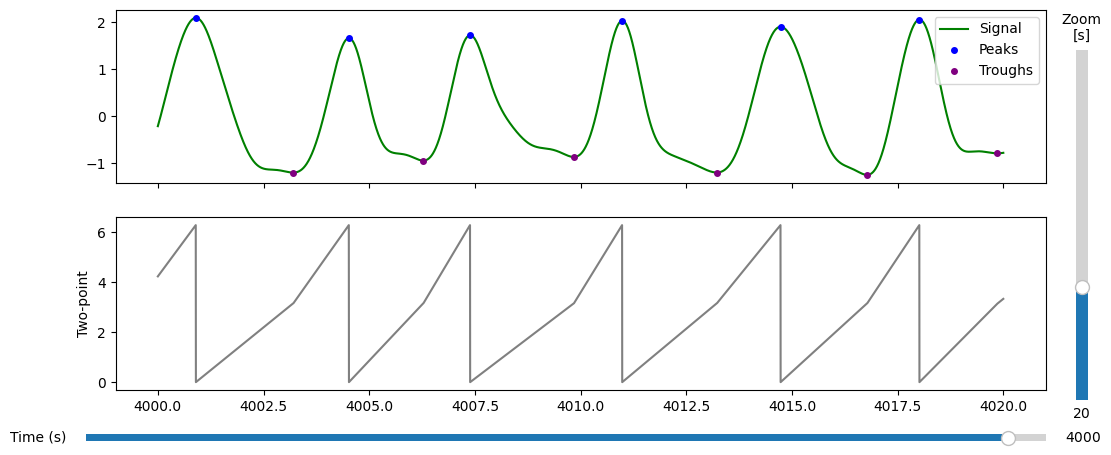

(<Figure size 1200x500 with 4 Axes>,
 array([<Axes: >, <Axes: ylabel='Two-point'>], dtype=object))

In [77]:
phase, peaks, troughs = raw.phase_linear(prominence=0.1, distance=0.5)

plot_phase_diagnostics(
            {"Two-point": phase},
            start = 4000,
            window_duration = 20,
            fs = raw.fs,
            data = raw.ts, #the preproccessed data 
            peaks=peaks,
            troughs=troughs
        )

## Extract phase angles at the time of stimulus presentation
Now, we will extract the phase angles corresponding to the events of interest. This will allow us to analyse the whether the respiration phase is aligned with the timing of the stimuli presented during the task. 

To acheive this, we first need to get the event timings. In the data used for this tutorial, the events are stored in a numpy array with $n$ rows and 3 columns. The first column holds the the sample index of the event, and the third column holds the trigger value (i.e. an integer that identifes the type of event).

In [78]:
events = data["events"]

trigger_vals = events[:, 2]
sample_indices = events[:, 0]

print("Triggers:", trigger_vals[:10])
print("Sample indices:", sample_indices[:10])

Triggers: [  3   5   9  35  37  41 416   3   5   9]
Sample indices: [121550 122000 122449 122891 123329 123797 124246 124920 125370 125819]


To make it easier to understand the data, we will convert the trigger values into a list of event names.

In [79]:
event_ids = {
    # stimulus leading up to the target stimulus 
    ## all are salient, but the fourth, fifth and sixth can be either regular or irregular 
    ## (i.e. they are either presented at the expected time or jittered)
    3: "salient/first",
    5: "salient/second",
    9: "salient/third",
    19: "salient/regular/fourth",
    21: "salient/regular/fifth",
    25: "salient/regular/sixth",
    35: "salient/irregular/fourth",
    37: "salient/irregular/fifth",
    41: "salient/irregular/sixth",

    # target stimulus
    ## can either be weak or omission
    ## the regular and irregular is used to indicate whether the proceeding stimulus was presented at the expected time or jittered
    ## the target is always presented at the expected time
    337: "weak/target/regular/hit",
    593: "weak/target/regular/miss",
    353: "weak/target/irregular/hit",
    609: "weak/target/irregular/miss",
    400: "omission/target/regular/hit",
    416: "omission/target/irregular/hit",
    656: "omission/target/regular/miss",
    672: "omission/target/irregular/miss",
}

event_labels = [event_ids.get(trig, "unknown") for trig in trigger_vals]
print(f"Event labels: {event_labels[:10]}")    

Event labels: ['salient/first', 'salient/second', 'salient/third', 'salient/irregular/fourth', 'salient/irregular/fifth', 'salient/irregular/sixth', 'omission/target/irregular/hit', 'salient/first', 'salient/second', 'salient/third']


Now that we have our event labels and the phase angles, we can find the phase angles corresponding to the experimental events.

In [82]:
phase_events = create_phase_events(
    phase_ts=phase,
    events=sample_indices,
    event_labels=event_labels
)

Rejected 0 out of 2100 events (0.0%)


The `PhaseEvents` object has a plotting function, so we can visualise the phase angles at the time of the events. This will allow us to see how the phase angles are distributed across the different event types.

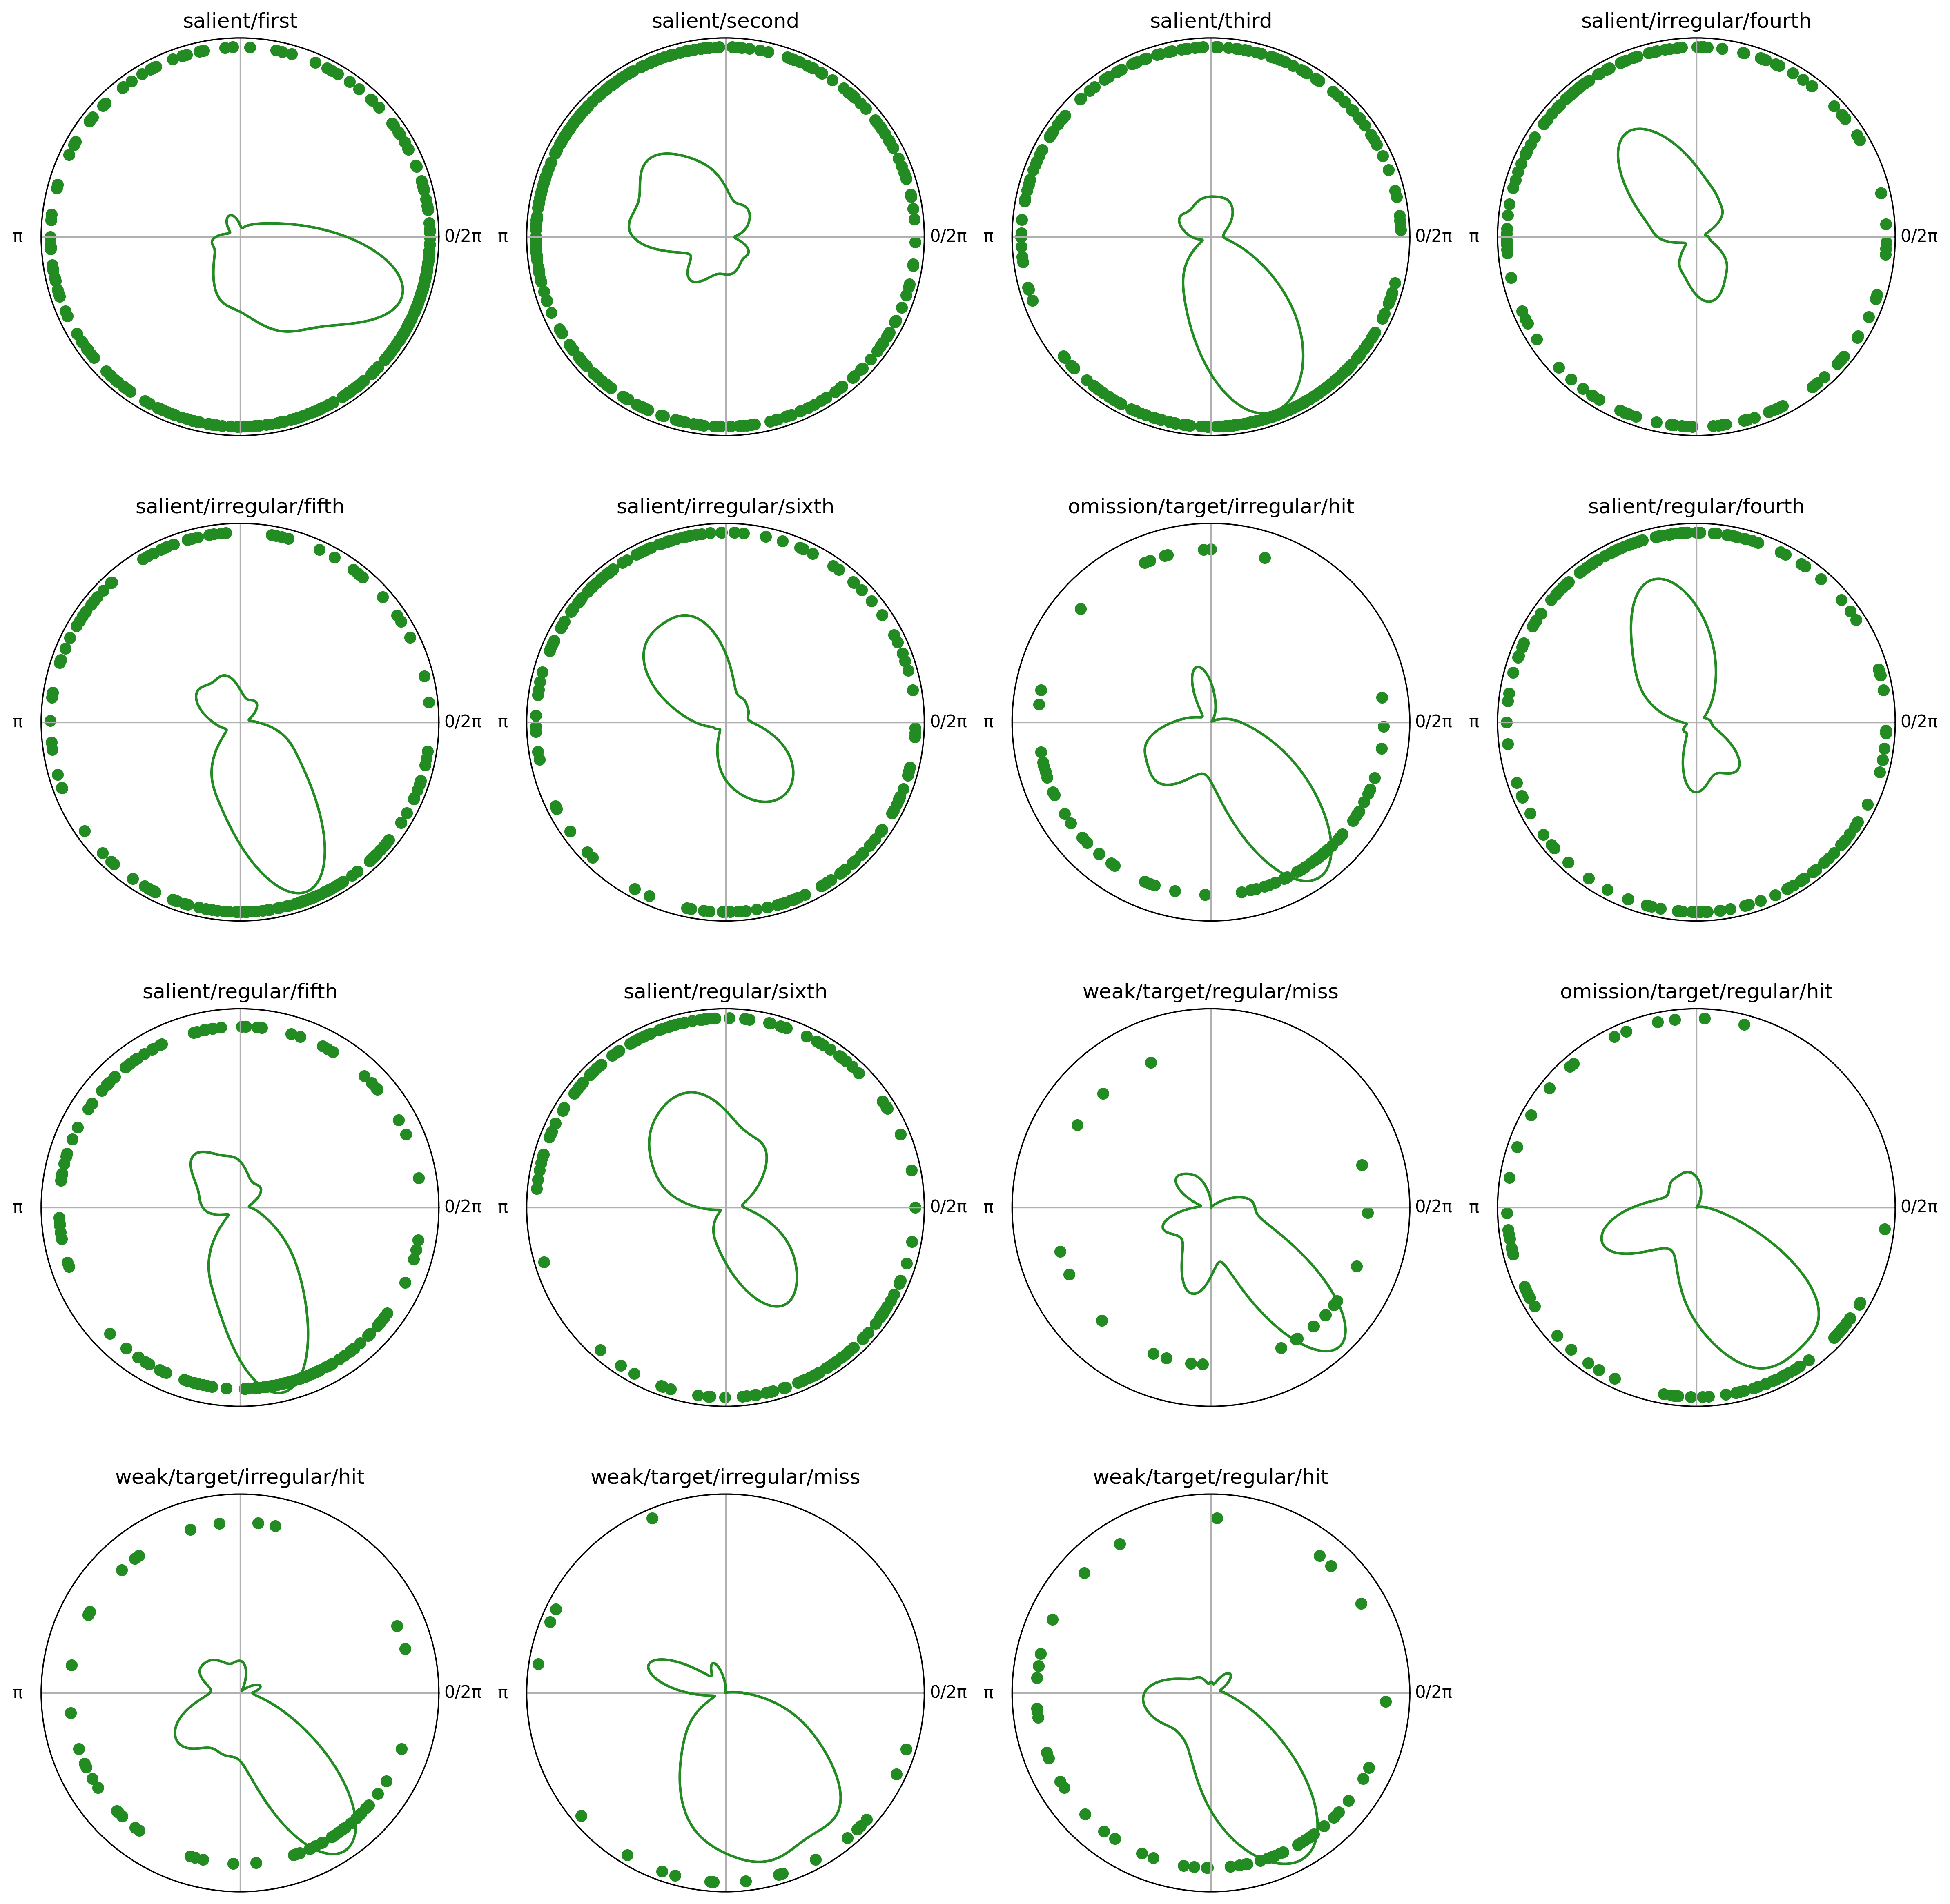

In [83]:
phase_events.plot()